In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/My Drive/NIKE_vs_ADIDAS-master')

In [4]:
train_dir = './TRAIN'
test_dir = './TEST'
size = 120
lr = 1e-3 

In [5]:
def label_img(img):
    word_label = img.split('_')[0] #gets the name of the brand
    if word_label == 'NIKE':
        return [1,0]
    
    elif word_label == 'ADIDAS':
        return [0,1]

In [6]:
def create_train_data():
    train_dataset = []
    for image in tqdm(os.listdir(train_dir)):
        label = label_img(image)
        path = os.path.join(train_dir, image)
        image = Image.open(path)
        
        #Grayscale conversion using PIL - channel L is for single channel
        #channel P is for mode or palettized
        image = image.convert('L')
        image = image.resize((size, size), Image.ANTIALIAS) #using this lib instead of cv2
        #eqvt of cv2 is cv2.cvtColor and cv2.resize( ,(bicubic, NN interpolation arg, etc)) 
        
        train_dataset.append([np.array(image), np.array(label)])
        
    shuffle(train_dataset)
    np.save('train_data.npy', train_dataset)
    return train_dataset

In [7]:
def process_test_data():
    test_dataset = []
    for image in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, image)
        if "DS_Store" not in path:
            image_idx = image.split('_')[1] #images are like NIKE_7 etc
            image = Image.open(path)
            image = image.convert('L')
            image = image.resize((size, size), Image.ANTIALIAS)
            
            test_dataset.append([np.array(image), np.array(image_idx)])
            
    shuffle(test_dataset)    
    np.save('test_data.npy', test_dataset)
    return test_dataset    

In [8]:
!pip install tflearn 

In [9]:
pip install tensorflow==1.13.2

In [11]:
#using tflearn instead of tensorflow/keras

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, size, size, 1], name = 'input')
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'adam', learning_rate = lr, loss = 'categorical_crossentropy', name = 'targets')
model = tflearn.DNN(convnet, tensorboard_verbose=3)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


[0 1]


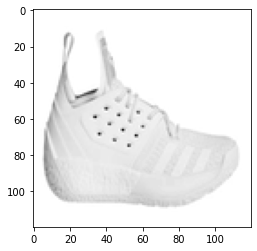

In [13]:
train_dataset = create_train_data()
plt.imshow(train_dataset[43][0], cmap = 'gray')
print(train_dataset[43][1])   

In [14]:
train = train_dataset[-90:]
print(len(train))

90


In [15]:
val = train_dataset[:-90]
print(len(val))

10


In [18]:
X = np.array([i[0] for i in train]).reshape(-1, size, size, 1)
y = [i[1] for i in train]

val_X = np.array([i[0] for i in val]).reshape(-1, size, size, 1)
val_y = [i[1] for i in val]

In [21]:
model.fit({'input':X}, {'targets':y}, n_epoch = 100, validation_set=({'input': val_X}, {'targets': val_y}), snapshot_step=50, show_metric=True)

Training Step: 199  | total loss: 0.06940 | time: 2.082s
| Adam | epoch: 100 | loss: 0.06940 - acc: 0.9912 -- iter: 64/90
Training Step: 200  | total loss: 0.06279 | time: 3.919s
| Adam | epoch: 100 | loss: 0.06279 - acc: 0.9921 | val_loss: 0.00443 - val_acc: 1.0000 -- iter: 90/90
--


100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


[0.7586345  0.24136546]
[0.00106233 0.99893767]
[0.32286942 0.6771306 ]
[0.99872607 0.00127396]
[0.01041912 0.98958087]
[0.5750291 0.4249709]
[0.01098289 0.9890171 ]
[0.99526715 0.00473282]
[0.01160982 0.9883902 ]
[0.00309564 0.9969043 ]


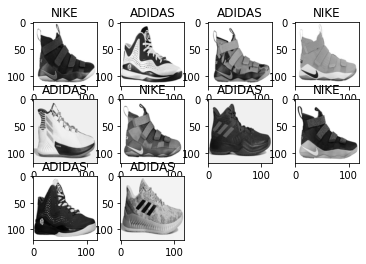

In [22]:
test_data = process_test_data()
fig = plt.figure()

for num, data in enumerate(test_data[:10]):
  image_idx = data[1]
  image_data = data[0]

  y = fig.add_subplot(3, 4, num + 1)
  original = image_data
  data = image_data.reshape(size, size, 1)
  output = model.predict([data])[0]
  print(output)
  if np.argmax(output) == 1:
    label = 'ADIDAS'

  else:
    label = 'NIKE'

  y.imshow(original, cmap = 'gray')
  plt.title(label)

plt.show()       